In [170]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import combinations
from scipy.stats import ttest_ind 

st_data = pd.read_csv("stud_math.xlt")
st_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [192]:
#function used in the initial screening of the numerical columns:
def nb_column_analysis(list_of_cols):
    for col in list_of_cols:
        print(col)
        print(st_data[col].describe())
        print(pd.DataFrame(st_data[col].value_counts()).sort_index())
        
#function used in the initial screening of the general(string) columns:
def str_column_analysis(list_of_cols):
    for col in list_of_cols:
        print(st_data[col].count())
        #print(pd.DataFrame(st_data[col].value_counts()))
        print(st_data.groupby(by = col).score.describe())
         
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', data=st_data,ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
      
def get_stat_dif(column):
    cols = st_data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(st_data.loc[st_data.loc[:, column] == comb[0], 'score'], 
                        st_data.loc[st_data.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [172]:
#check data to be modeled:
pd.DataFrame(st_data.score.value_counts()).sort_index()

,score
0.0,37
20.0,1
25.0,7
30.0,15
35.0,9
40.0,31
45.0,27
50.0,54
55.0,46
60.0,31


In [178]:
#drop rows with unknown score:
st_data.drop(st_data[st_data.score.isna()].index, inplace = True)
#get list of columns
st_data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [174]:
# get basic statistics of all numbered columns
nb_column_analysis(['age', 'Medu', 'Fedu', 'traveltime', 'studytime','failures', 
                    'studytime, granular', 'famrel', 'freetime', 'goout', 'health', 'absences', 'score'])

age
count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64
    age
15   82
16  103
17   98
18   80
19   21
20    3
21    1
22    1
Medu
count    386.000000
mean       2.766839
std        1.094277
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64
     Medu
0.0     3
1.0    56
2.0   100
3.0    96
4.0   131
Fedu
count    365.000000
mean       2.627397
std        2.241790
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64
      Fedu
0.0      2
1.0     75
2.0    105
3.0     94
4.0     88
40.0     1
traveltime
count    361.000000
mean       1.434903
std        0.692660
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64
     travelti

In [175]:
#deal with outliers:
st_data.Fedu[st_data.Fedu == 40.0] = None
st_data.famrel[st_data.famrel == -1.0] = 1.0

<ipython-input-175-c15b08f0f832>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_data.Fedu[st_data.Fedu == 40.0] = None
<ipython-input-175-c15b08f0f832>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_data.famrel[st_data.famrel == -1.0] = 1.0


In [179]:
#find interval of acceptable values
perc25 = st_data.absences.quantile(0.25)
perc75 = st_data.absences.quantile(0.75)
iqr = perc75 - perc25
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), 
      "IQR: {}, ".format(iqr), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*iqr, l=perc75 + 1.5*iqr))

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


In [180]:
#remove outliers, with wider interval 
st_data.absences[st_data.absences > 100] = None

<ipython-input-180-e4d4b0b28115>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_data.absences[st_data.absences > 100] = None


In [181]:
#do initial analysis of text data
str_column_analysis(['school', 'sex', 'address', 'famsize', 'Pstatus',
                     'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 
                     'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'])

389
        count       mean        std  min   25%   50%   75%    max
school                                                           
GP      344.0  52.630814  23.116772  0.0  40.0  55.0  70.0  100.0
MS       45.0  49.444444  21.379212  0.0  40.0  50.0  65.0   95.0
389
     count       mean        std  min   25%   50%   75%    max
sex                                                           
F    204.0  50.098039  23.070682  0.0  40.0  55.0  65.0   95.0
M    185.0  54.648649  22.572608  0.0  45.0  55.0  70.0  100.0
374
         count       mean        std  min   25%   50%   75%    max
address                                                           
R         83.0  46.927711  23.148926  0.0  35.0  50.0  60.0   95.0
U        291.0  53.573883  22.824908  0.0  45.0  55.0  70.0  100.0
362
         count       mean        std  min   25%   50%   75%    max
famsize                                                           
GT3      255.0  51.509804  23.388513  0.0  40.0  55.0  70.0  100.0

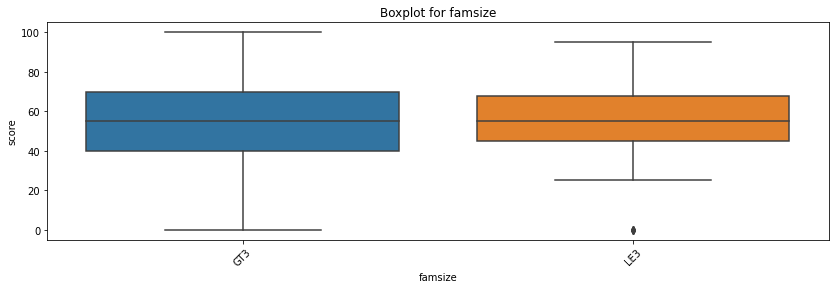

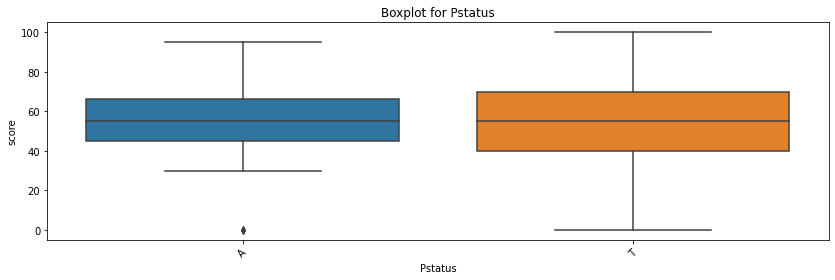

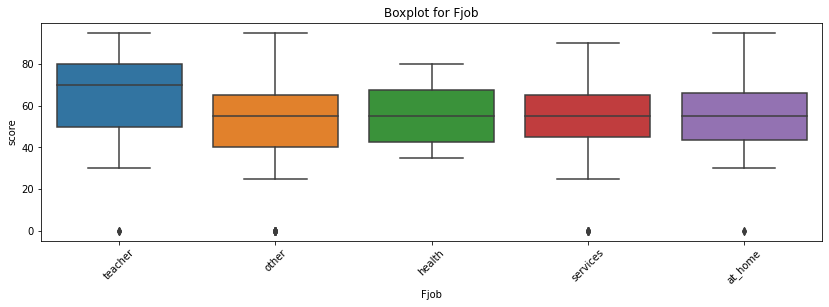

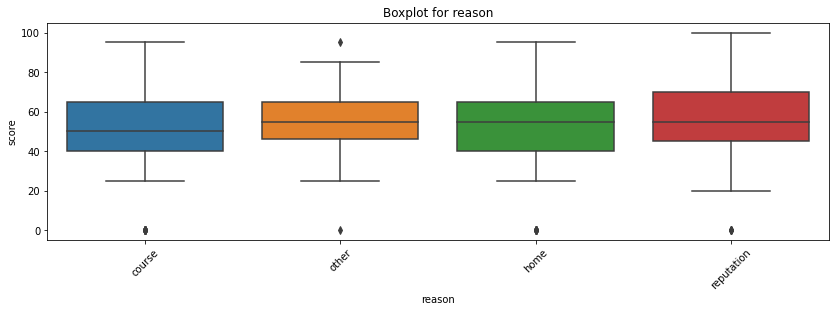

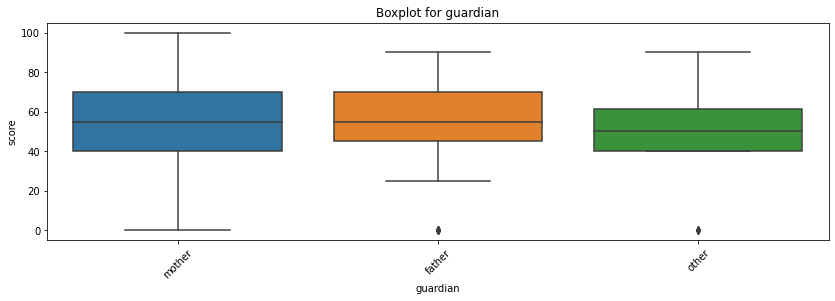

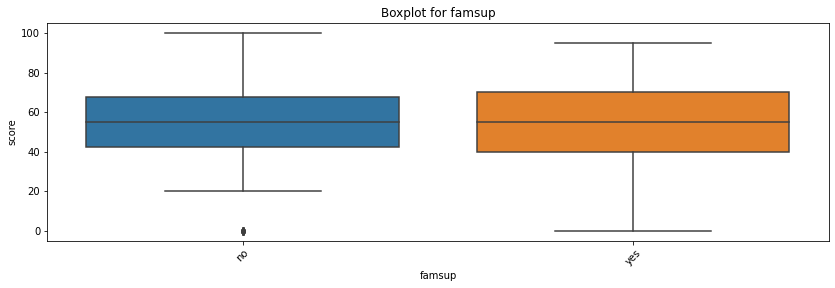

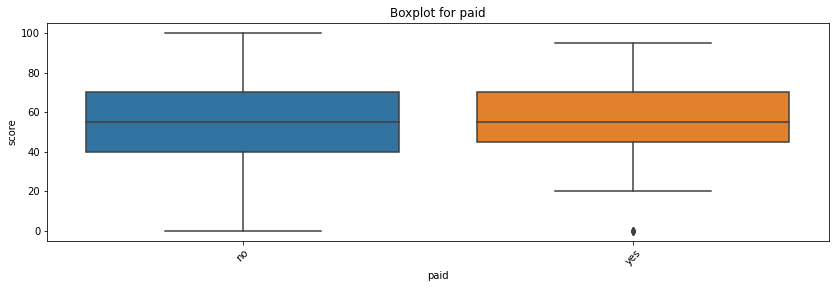

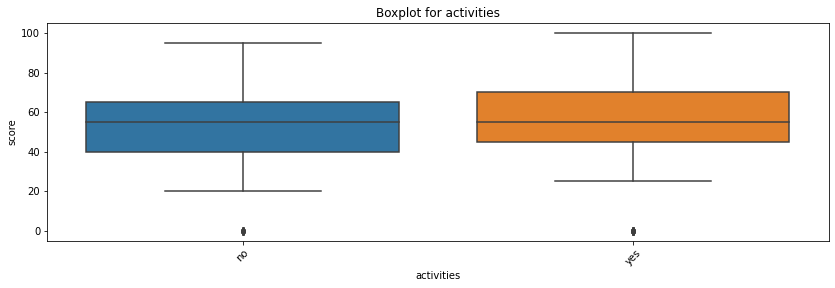

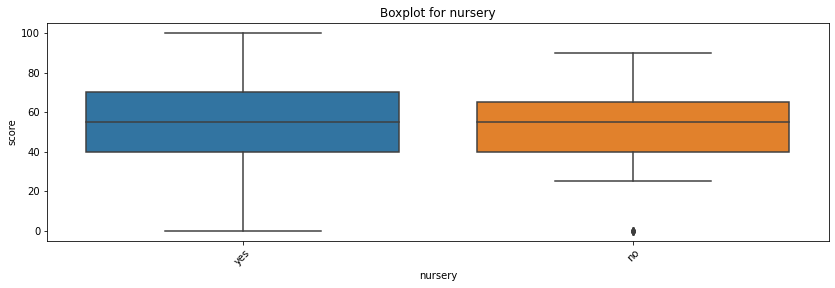

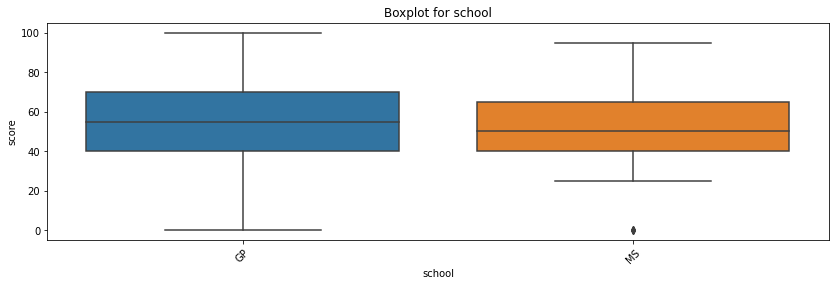

In [194]:
#get boxplots for text data
for col in ['famsize', 'Pstatus', 'Fjob', 'reason', 'guardian', 'famsup', 'paid', 'activities', 'nursery', 'school']:
    get_boxplot(col)

In [195]:
#find text columns statistically explaining score
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus',
                     'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 
                     'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


In [196]:
#drop columns which do not explain score
st_data.drop(['school', 'famsize', 'Pstatus', 'Fjob', 'guardian', 
              'famsup', 'paid', 'activities', 'nursery'], axis = 1, inplace = True)

In [197]:
st_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex                  389 non-null    object 
 1   age                  389 non-null    int64  
 2   address              374 non-null    object 
 3   Medu                 386 non-null    float64
 4   Fedu                 364 non-null    float64
 5   Mjob                 370 non-null    object 
 6   reason               372 non-null    object 
 7   traveltime           361 non-null    float64
 8   studytime            382 non-null    float64
 9   failures             367 non-null    float64
 10  schoolsup            380 non-null    object 
 11  studytime, granular  382 non-null    float64
 12  higher               369 non-null    object 
 13  internet             355 non-null    object 
 14  romantic             358 non-null    object 
 15  famrel               362 non-null    flo

In [198]:
#perform initial statistical analysis of numerical columns:
nb_column_analysis(['age', 'Medu', 'Fedu', 'traveltime', 'studytime','failures', 
                    'studytime, granular', 'famrel', 'freetime', 'goout', 'health', 'absences', 'score'])

age
count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64
    age
15   82
16  103
17   98
18   80
19   21
20    3
21    1
22    1
Medu
count    386.000000
mean       2.766839
std        1.094277
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64
     Medu
0.0     3
1.0    56
2.0   100
3.0    96
4.0   131
Fedu
count    364.000000
mean       2.524725
std        1.086833
min        0.000000
25%        2.000000
50%        2.500000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64
     Fedu
0.0     2
1.0    75
2.0   105
3.0    94
4.0    88
traveltime
count    361.000000
mean       1.434903
std        0.692660
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64
     traveltime
1.0         23

In [199]:
#get their correlations:
st_data.corr()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.146736,-0.147952,0.073146,-0.018227,0.205919,0.018227,0.058768,0.016099,0.121115,-0.068103,0.171939,-0.155726
Medu,-0.146736,1.000000,0.626536,-0.165838,0.081032,-0.240319,-0.081032,-0.003697,0.038265,0.072320,-0.048331,0.096016,0.213349
Fedu,-0.147952,0.626536,1.000000,-0.142170,0.013009,-0.272352,-0.013009,-0.021456,-0.012749,0.054938,0.017321,0.038860,0.130002
traveltime,0.073146,-0.165838,-0.142170,1.000000,-0.105910,0.049738,0.105910,-0.032413,-0.026299,0.032629,-0.011724,-0.014284,-0.070559
studytime,-0.018227,0.081032,0.013009,-0.105910,1.000000,-0.181947,-1.000000,0.039899,-0.125066,-0.053831,-0.079180,-0.065809,0.115741
failures,0.205919,-0.240319,-0.272352,0.049738,-0.181947,1.000000,0.181947,-0.021068,0.091608,0.107747,0.088013,0.068090,-0.344338
"studytime, granular",0.018227,-0.081032,-0.013009,0.105910,-1.000000,0.181947,1.000000,-0.039899,0.125066,0.053831,0.079180,0.065809,-0.115741
famrel,0.058768,-0.003697,-0.021456,-0.032413,0.039899,-0.021068,-0.039899,1.000000,0.171165,0.072291,0.089074,-0.051829,0.055305
freetime,0.016099,0.038265,-0.012749,-0.026299,-0.125066,0.091608,0.125066,0.171165,1.000000,0.296338,0.064315,-0.068436,0.019026
goout,0.121115,0.072320,0.054938,0.032629,-0.053831,0.107747,0.053831,0.072291,0.296338,1.000000,-0.018026,0.038435,-0.129685


In [200]:
#remove fully correlated to 'studytime' column
st_data.drop(['studytime, granular'], axis = 1, inplace = True)

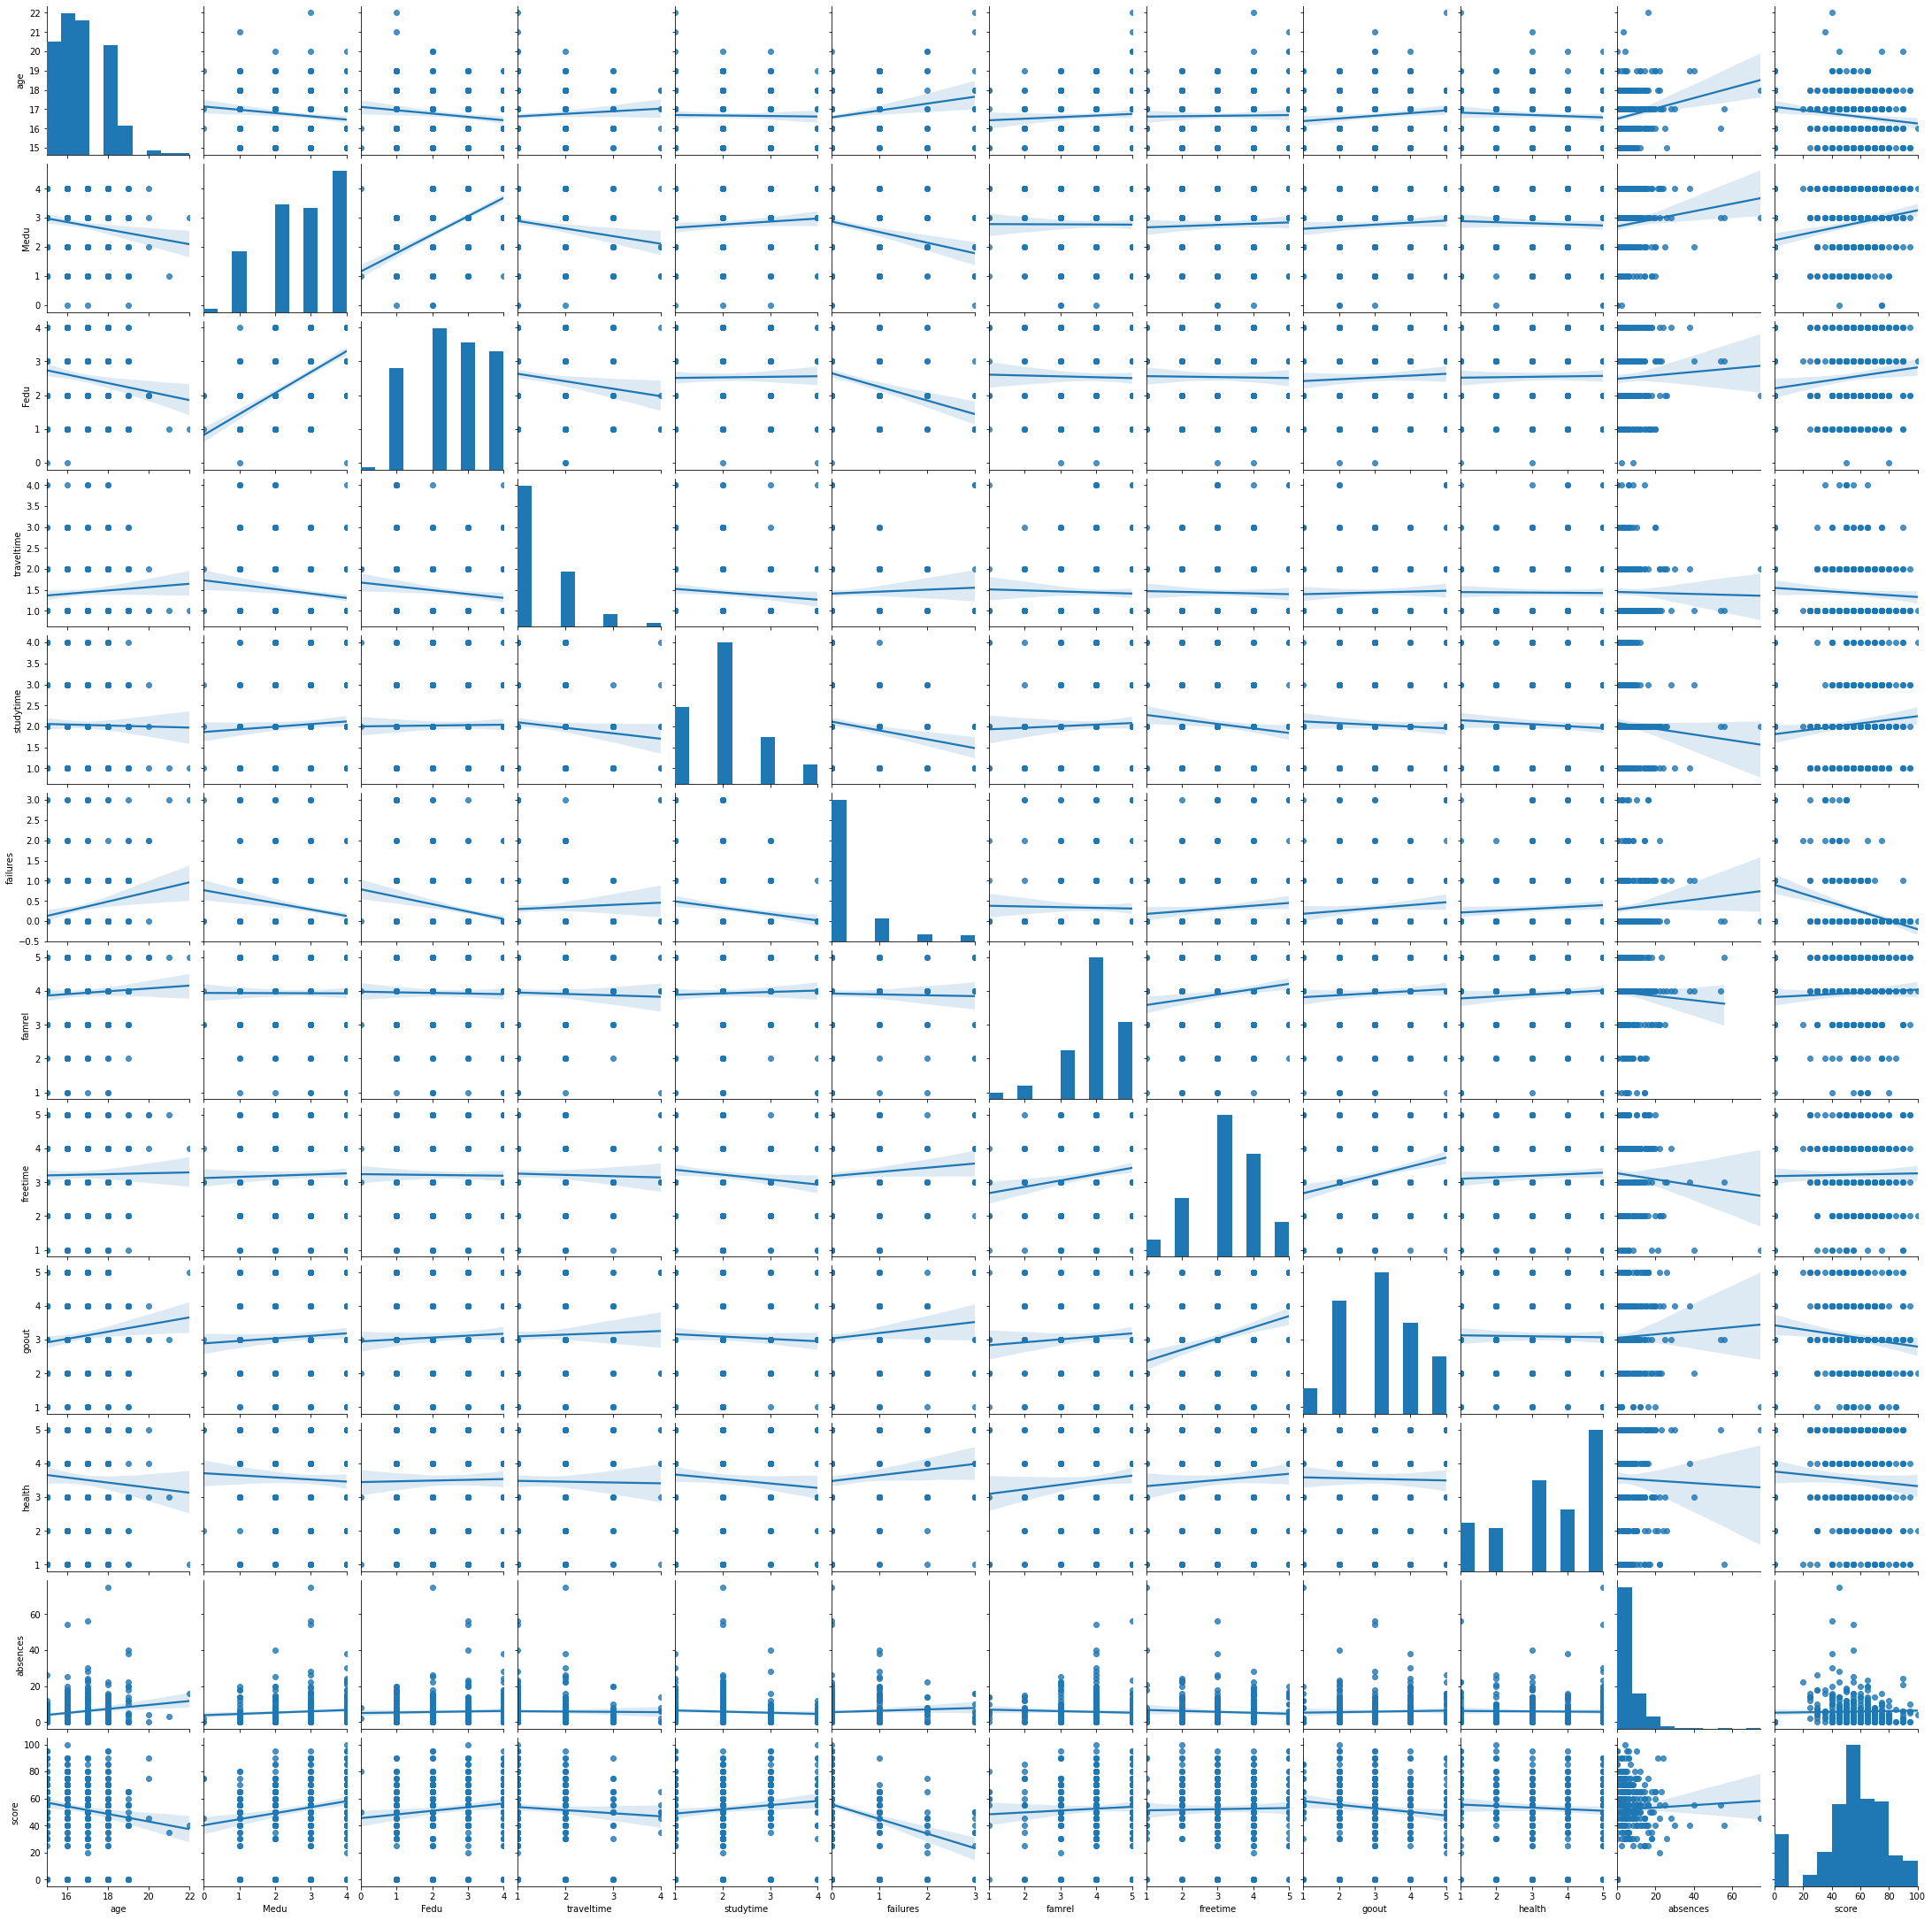

In [201]:
#get plots:
sns.pairplot(st_data, kind = 'reg')